## SVM

In [ ]:
import random
import matplotlib.pyplot as plt

import numpy as np

import pickle
import struct

# Third-party libraries
import numpy as np

import plotly
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings('ignore')
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=False)
import random
from tqdm import tqdm_notebook
import plotly.offline.offline as of

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import matplotlib.pyplot as plt
from sklearn import svm

### 1 数据加载与可视化

In [2]:
def load_imgs(path):

    with open(path, 'rb') as f:  # 'rb'以二进制读取文件
        #  读取image文件前4个整型数字
        #  unpack(fmt, string)按照给定的格式(fmt)解析字节流string，返回解析出来的tuple
        # >4I 大端模式 4个Int I: int 4*4=16
        # f.read(16)读取前16个字节的数据
        magic, num, rows, cols = struct.unpack('>4I', f.read(16))  # 读完后缓冲区少了这16字节内容
        #  整个images数据大小为60000*28*28
        # imgs_size = num * rows *cols
        imgs = np.fromfile(f, dtype=np.uint8).reshape(num, rows * cols)  # nums * img_size

    return imgs




def load_labels(path):
    
    with open(path, 'rb') as f:
        magic, num = struct.unpack('>2I', f.read(8))
        #  读取label文件前2个整形数字，label的长度为num
        labels = np.fromfile(f, dtype=np.uint8)
    return labels


def generate_data(img_path, label_path, class_list):

    # 加载图像数据和label
    imgs = load_imgs(img_path)
    labels = load_labels(label_path)

    # 选取特定类别生成所需要的数据
    img_class = []
    label_class = []
    for c in class_list:
        index = np.where(labels == c)  # 返回的是label为指定值的index，格式([index的list],dtype)
        img_class.extend(imgs[index[0]])
        label_class.extend((labels[index[0]]))
    label_class = np.array(label_class)

    return [img_class, label_class]

def generate_data_and_norm(img_path, label_path, class_list,nums = None):

    
    # 加载图像数据和label
    imgs = load_imgs(img_path)
    labels = load_labels(label_path)

    # 选取特定类别生成所需要的数据
    img_class = []
    label_class = []
    for c in class_list:
        index = np.where(labels == c)  # 返回的是label为指定值的index，格式([index的list],dtype)
        img_class.extend(imgs[index[0]])
        label_class.extend((labels[index[0]]))
    
    if nums:
        rate = nums/len(img_class)
        img_class = []
        label_class = []

        
        for c in class_list:
            print(int(rate*len(imgs[index[0]])))
            index = np.where(labels == c)  # 返回的是label为指定值的index，格式([index的list],dtype)
            img_class.extend(imgs[index[0]][:int(rate*len(imgs[index[0]]))])
            label_class.extend((labels[index[0]][:int(rate*len(imgs[index[0]]))]))
    label_class = np.array(label_class)
    return [np.array(img_class), np.array(label_class)]

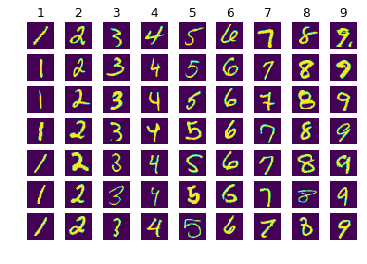

In [3]:
# 文件路径
TRAIN_IMG_PATH = "./train-images-idx3-ubyte"
TRAIN_LABEL_PATH = "./train-labels-idx1-ubyte"
TEST_IMG_PATH = "./t10k-images-idx3-ubyte"
TEST_LABEL_PATH = "./t10k-labels-idx1-ubyte"
# 训练&测试的指定类别
img_class = [1,2,3,4,5,6,7,8,9]
# 数据加载
train_data = generate_data(TRAIN_IMG_PATH, TRAIN_LABEL_PATH, img_class)
test_data = generate_data(TEST_IMG_PATH, TEST_LABEL_PATH, img_class)


num_classes = len(img_class)
samples_per_class = 7
for y, cls in enumerate(img_class):
    
    idxs = np.flatnonzero(train_data[1] == cls)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(train_data[0][idx].astype('uint8').reshape((28,28)))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# 训练&测试的指定类别
img_class = [7,8,9]
# 数据加载
train_data = generate_data_and_norm(TRAIN_IMG_PATH, TRAIN_LABEL_PATH, img_class,nums = 5000)
test_data = generate_data_and_norm(TEST_IMG_PATH, TEST_LABEL_PATH, img_class)

1646
1734
1619


##### 降维可视化

In [5]:
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(train_data[0],train_data[1])
train_2d = lda.transform(train_data[0])
train_2d.shape

(4999, 2)

In [6]:
test_2d = lda.transform(test_data[0])

In [7]:
train_data[1].shape

(4999,)

In [8]:
fig = go.Figure()

for i in [8,9]:
    trace = go.Scatter(
    x = train_2d[np.where(train_data[1]==i)][:,0],y = train_2d[np.where(train_data[1]==i)][:,1],
        mode='markers',
        name ="${}$".format(i))
    fig.add_trace(trace)

fig.update_layout(
    xaxis_title='$x_1$',
    yaxis_title='$x_2$',
)
fig.show()

In [9]:
train = [train_data[0][np.where(train_data[1]!=7)],train_data[1][np.where(train_data[1]!=7)]]
test = [test_data[0][np.where(test_data[1]!=7)],test_data[1][np.where(test_data[1]!=7)]]

### 2 不同C的影响

In [10]:
C = [1e-3, 0.1, 0.5, 1, 10, 100]
kernel = 'linear'

result = []
for i in C:
    s = svm.SVC(C=i, kernel=kernel)
    s.fit(train_data[0], train_data[1])
    print('C={}, kernel={}, accuracy={}'.format(i, kernel, s.score(test_data[0], test_data[1])))
    result.append(s.score(test_data[0], test_data[1]))

C=0.001, kernel=linear, accuracy=0.9422118897376287
C=0.1, kernel=linear, accuracy=0.9422118897376287
C=0.5, kernel=linear, accuracy=0.9422118897376287
C=1, kernel=linear, accuracy=0.9422118897376287
C=10, kernel=linear, accuracy=0.9422118897376287
C=100, kernel=linear, accuracy=0.9422118897376287


In [11]:
trace_basic = [go.Bar(
            x = ["C = {}".format(c) for c in C],
            y = result,
    )]
# Layout
layout_basic = go.Layout(
            title = '不同C的影响',
            yaxis = go.XAxis(range = [0.9,0.95]),
    )
# Figure
figure_basic = go.Figure(data = trace_basic, layout = layout_basic)

figure_basic.show()

### 3 不同核函数的影响

In [12]:
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
result_k = []
C = 1
for i in kernel:
    s = svm.SVC(C=C, kernel=i)
    s.fit(train_data[0], train_data[1])
    y_pred = s.predict(test_data[0])
    print('C={}, kernel={}, accuracy={}'.format(C, i, s.score(test_data[0], test_data[1])))
    result_k.append(s.score(test_data[0], test_data[1]))

C=1, kernel=linear, accuracy=0.9422118897376287
C=1, kernel=poly, accuracy=0.9820657588840916
C=1, kernel=rbf, accuracy=0.34141481235469945
C=1, kernel=sigmoid, accuracy=0.34141481235469945


In [13]:
trace_basic = [go.Bar(
            x = ["kernel = {}".format(k) for k in kernel],
            y = result_k,
    )]
# Layout
layout_basic = go.Layout(
            title = '不同kernel的影响',
            yaxis = go.XAxis(range = [0.1,1]),
    )
# Figure
figure_basic = go.Figure(data = trace_basic, layout = layout_basic)

figure_basic.show()